In [1]:
# load libraries 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# set seeds
torch.manual_seed(2020)
np.random.seed(2020)

In [3]:
# load data
train = np.loadtxt("ECG200_TRAIN.txt")
test  = np.loadtxt("ECG200_TEST.txt")

# the first column is label
X_train = train[:, 1:]       
y_train = train[:, 0].astype(int)     
X_test  = test[:, 1:]              
y_test  = test[:, 0].astype(int)

# original label is -1, +1, we convert to 0, 1 for BCE
y_train = (y_train == 1).astype(np.float32)
y_test  = (y_test == 1).astype(np.float32)


# convert to torch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (N,1)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


print("X_train:", X_train.shape, "y_train:", y_train.shape)

X_train: torch.Size([100, 96]) y_train: torch.Size([100, 1])


In [4]:
# define a baseline model of logistic regression

class LogisticECG(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(96, 1) 

    def forward(self, x):
        logits = self.linear(x)
        prob = torch.sigmoid(logits)        
        return prob                       

# not in use in this step
# model = LogisticECG()

In [5]:
# define an advanced model of MLP with 1 hidden layer

class MLPECG(nn.Module):
    def __init__(self, hidden_dim):    
        super().__init__()
        self.fc1 = nn.Linear(96, hidden_dim)   
        self.act = nn.ReLU()                   
        self.fc2 = nn.Linear(hidden_dim, 1)    

    def forward(self, x):
        h = self.fc1(x)                     
        h = self.act(h)                       
        logits = self.fc2(h)                    
        prob = torch.sigmoid(logits)           
        return prob


hidden_dim = 32
model = MLPECG(hidden_dim = hidden_dim) 

In [6]:
# print the model size (number of parameters)
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

Number of parameters: 3137


In [7]:

loss_function = nn.BCELoss()                       
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Full-batch 
num_epochs = 200


# history for plot
loss_history = []
acc_history = [] 


# model training

for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()
    y_prob = model(X_train)                
    loss = loss_function(y_prob, y_train)       
    loss.backward()
    optimizer.step()



    # compute training accuracy
    with torch.no_grad():
        y_prob_new = model(X_train)
        loss_new = loss_function(y_prob_new, y_train)
        train_pred = (y_prob_new >= 0.5).float()
        train_acc = (train_pred == y_train).float().mean().item()
    


    
    loss_history.append(loss_new.item())
    acc_history.append(train_acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Loss = {loss_new.item():.4f} | Acc = {train_acc:.3f}")


Epoch   0 | Loss = 0.6274 | Acc = 0.820
Epoch  20 | Loss = 0.1898 | Acc = 0.930
Epoch  40 | Loss = 0.0590 | Acc = 1.000
Epoch  60 | Loss = 0.0157 | Acc = 1.000
Epoch  80 | Loss = 0.0063 | Acc = 1.000
Epoch 100 | Loss = 0.0036 | Acc = 1.000
Epoch 120 | Loss = 0.0024 | Acc = 1.000
Epoch 140 | Loss = 0.0018 | Acc = 1.000
Epoch 160 | Loss = 0.0014 | Acc = 1.000
Epoch 180 | Loss = 0.0011 | Acc = 1.000


In [8]:
# evaluate
model.eval()
with torch.no_grad():
    test_prob = model(X_test)        
    test_pred = (test_prob >= 0.5).float()
    acc = (test_pred == y_test).float().mean().item()

print("Test Accuracy:", round(acc, 3))

Test Accuracy: 0.87


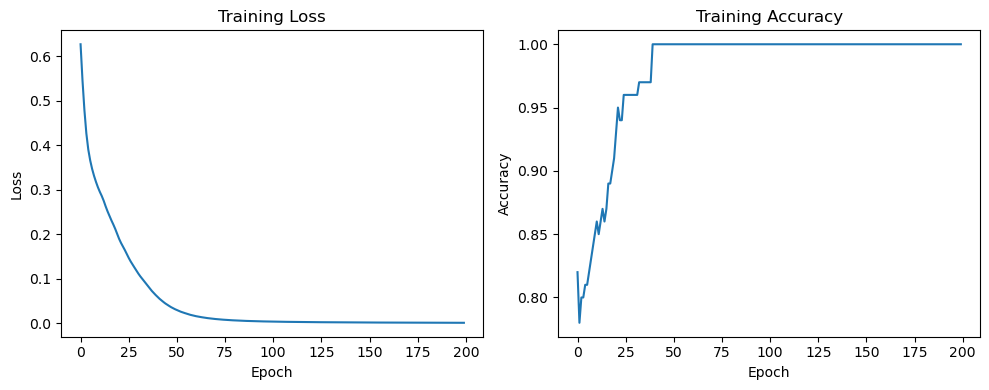

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(acc_history)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()
